In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('../train_preprocess/train_preprocess_data_aug.csv')
train_df

,질문,답변
0,면진장치가 뭐야?,면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 ...
1,면진장치가 뭐야?,"면진장치란 건물의 지반에서 발생하는 진동 에너지를 흡수하여 건물을 보호하고, 진동을..."
2,면진장치가 뭐야?,면진장치란 지반으로부터 발생하는 진동 에너지를 흡수하여 건물에 전달되는 진동을 줄여...
3,면진장치가 뭐야?,면진장치는 건물의 지반으로부터 오는 진동 에너지를 흡수하여 건물에 전달되는 진동을 ...
4,면진장치가 뭐야?,면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동...
...,...,...
6997,현관문 주위 결로의 대책은 뭐야? 또한 현관문 주위 결로의 원인은 뭐야??,현관문 주위 결로의 대책은 규격제품을 사용하고 방화문 현관문 내부 종이 허니컴 사이...
6998,"부엌 및 욕실의 결로의 원인은 뭐야? 또한 AD, PD에 면한 벽체 결로에 대한 대...",부엌이나 욕실의 경우 외벽이나 비 난방공간에 접한 면이 벽체의 일부인 부엌이나 욕실...
6999,발코니에 결로가 발생하는 원인은 뭐야? 또한 벽장 부위 결로의 원인이 뭐야??,발코니에 결로가 발생하는 원인은 발코니에 단열 및 방습조치가 되지 않은 상태에서 실...
7000,부엌 및 욕실의 결로의 대책은 뭐야? 또한 외벽 모서리 부위에 결로가 발생하는 원인...,부엌 및 욕실의 결로에 대한 대책은 환기구 설치입니다. 부엌 및 욕실의 결로는 주로...


In [3]:
length = train_df['답변'].apply(lambda x: len(x.split('.')))
length.describe()

count    7002.000000
mean        4.270637
std         2.384248
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        34.000000
Name: 답변, dtype: float64

In [ ]:

sns.boxplot(data=length)
plt.title('Boxplot of Answer Length')
plt.show()

In [4]:
from huggingface_hub import notebook_login

notebook_login()

## 토크나이징한 데이터 길이 분석

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
from tqdm.notebook import tqdm

In [6]:
# model = AutoModelForCausalLM.from_pretrained('beomi/llama-2-ko-7b', quantization_config=bnb_config, device_map={'': 0})
# fine-tuning으로 사용할 foundation model의 tokenizer 사용
model_id = "beomi/llama-2-koen-13b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id
    )

In [7]:
tokenizer

LlamaTokenizerFast(name_or_path='beomi/llama-2-koen-13b', vocab_size=46336, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	46331: AddedToken("<|sep|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	46332: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	46333: AddedToken("<|acc|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	46334:

In [8]:
# 데이터 포맷팅 및 토크나이징
formatted_data = []
for _, row in tqdm(train_df.iterrows(), total = len(train_df)):
#     input_text = f"당신은 질문에 답변하는 역할을 하는 챗봇입니다. 사용자의 질문에 올바른 답변을 하세요.\n### 질문: {row['질문']}\n### 답변: {row['답변']}"+tokenizer.eos_token
    input_text = row['답변'] + tokenizer.eos_token
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    formatted_data.append(input_ids)
print('Done.')

  0%|          | 0/7002 [00:00<?, ?it/s]

Done.


In [9]:
train_length = []
for i in range(len(formatted_data)):
    train_length.append(len(formatted_data[i][0]))
train_length = np.array(train_length)
train_length

array([ 29,  49,  63, ...,  96, 145,  89])

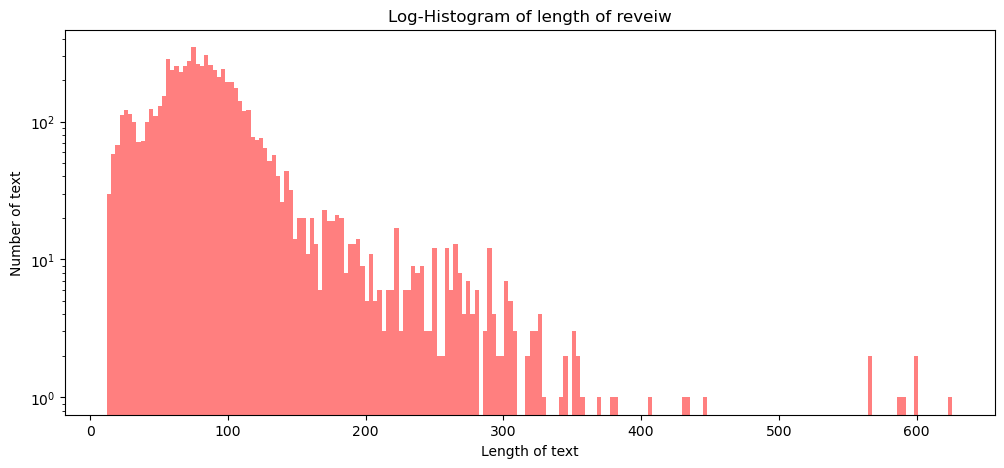

In [10]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color = 'r', label = 'word')
plt.yscale('log')
# 그래프 제목
plt.title('Log-Histogram of length of reveiw')
# 그래프 x 축 라벨
plt.xlabel('Length of text')
# 그래프 y 축 라벨
plt.ylabel('Number of text')
plt.show()

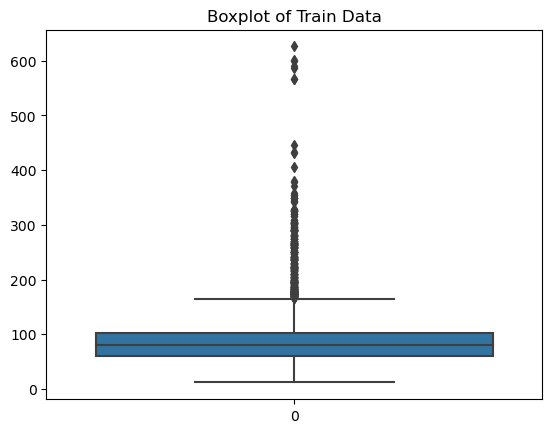

In [11]:
# 상자 그림(Boxplot) 그리기
sns.boxplot(data=train_length)
# 그래프 제목 추가
plt.title('Boxplot of Train Data')
# 그래프 표시
plt.show()

In [12]:
print('텍스트 길이 최댓값: {}'.format(np.max(train_length)))
print('텍스트 길이 최솟값: {}'.format(np.min(train_length)))
print('텍스트 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('텍스트 길이 중간값: {}'.format(np.median(train_length)))
print('텍스트 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('텍스트 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))

텍스트 길이 최댓값: 626
텍스트 길이 최솟값: 12
텍스트 길이 평균값: 87.36
텍스트 길이 표준편차: 50.45
텍스트 길이 중간값: 80.0
텍스트 길이 제1사분위: 60.0
텍스트 길이 제3사분위: 102.0
